In [90]:
%%capture
! pip install xclim

In [91]:
import xesmf
import xarray as xr
import numpy as np
from science_validation_manual import *
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import seaborn as sbn

In [92]:
import rhg_compute_tools.kubernetes as rhgk

In [ ]:
client, cluster = rhgk.get_micro_cluster()

In [144]:
cluster.scale(350)

In [145]:
cluster

# Output : test workflow for EC-Earth3 precip, only ssp370

In [146]:
# from workflow : https://argo.cildc6.org/workflows/default/biascorrectdownscale-precipitation-dev-lkbcg?tab=workflow&nodeId=biascorrectdownscale-precipitation-dev-lkbcg-1820029764&nodePanelView=inputs-outputs

datadict = {
    'reference-qdm': 'gs://support-c23ff1a3/qdm-reference/pr/v20220201000555.zarr',
    'reference-qplad-fine': 'gs://support-c23ff1a3/qplad-fine-reference/pr/v20220201000555.zarr',
    'reference-qplad-coarse': 'gs://support-c23ff1a3/qplad-coarse-reference/pr/v20220201000555.zarr',
    'gcm-clean': 'gs://clean-b1dbca25/cmip6/ScenarioMIP/EC-Earth-Consortium/EC-Earth3/ssp370/r1i1p1f1/day/pr/gr/v20200310.zarr',
    'gcm-clean-historical': 'gs://clean-b1dbca25/cmip6/CMIP/EC-Earth-Consortium/EC-Earth3/training/r1i1p1f1/day/pr/gr/v20200310.zarr',
    'gcm-biascorrected':'gs://biascorrected-492e989a/stage/ScenarioMIP/EC-Earth-Consortium/EC-Earth3/ssp370/r1i1p1f1/day/pr/gr/v20220201015809.zarr',
    'gcm-downscaled': 'gs://downscaled-288ec5ac/stage/ScenarioMIP/EC-Earth-Consortium/EC-Earth3/ssp370/r1i1p1f1/day/pr/gr/v20220201015809.zarr',
    'reference-clean': 'gs://clean-b1dbca25/reanalysis/ERA-5/F320/pr.1995-2015.F320.zarr'
}

In [147]:
for key, val in datadict.items():
    datadict[key] = read_gcs_zarr(val)['pr']

## 1. bidecadal maps of 
### - the mean among values > 1 across time
### - the max value across time
#### Note : for the mean, color bar ranges from 0-20 (mm), and for the max, 0-100.

In [108]:
def series_two_decades(start, end, datadict):
    
    reference_clean_mean = datadict['reference-clean'].sel({'time': slice('1994-12-17', '2015-01-15', None)}).where(datadict['reference-clean']>1).mean('time').compute()
    gcm_training_mean = datadict['gcm-clean-historical'].sel({'time': slice('1994-12-17', '2015-01-15', None)}).where(datadict['gcm-clean-historical']>1).mean('time').compute()
    gcm_clean_mean = datadict['gcm-clean'].sel(time=slice(start, end)).where(datadict['gcm-clean']>1).mean('time').compute()
    biascorrected_mean = datadict['gcm-biascorrected'].sel(time=slice(start, end)).where(datadict['gcm-biascorrected']>1).mean('time').compute()
    downscaled_mean = datadict['gcm-downscaled'].sel(time=slice(start, end)).where(datadict['gcm-downscaled']>1).mean('time').compute()
    
    plotdict = {
        'reference_clean_mean': reference_clean_mean,
        'gcm_training_mean': gcm_training_mean,
        'gcm_ssp370_mean': gcm_clean_mean,
        'biascorrected_clean_mean': biascorrected_mean,
        'downscaled_clean_mean': downscaled_mean
    }
    
    simple_plot_series(da_dict=plotdict, vmin=0, vmax=20, size=[40, 40])
    
    reference_clean_max = datadict['reference-clean'].sel({'time': slice('1994-12-17', '2015-01-15', None)}).max('time').compute()
    gcm_training_max = datadict['gcm-clean-historical'].sel({'time': slice('1994-12-17', '2015-01-15', None)}).max('time').compute()
    gcm_clean_max = datadict['gcm-clean'].sel(time=slice(start, end)).max('time').compute()
    biascorrected_max = datadict['gcm-biascorrected'].sel(time=slice(start, end)).max('time').compute()
    downscaled_max = datadict['gcm-downscaled'].sel(time=slice(start, end)).max('time').compute()
    
    plotdict = {
        'reference_clean_max': reference_clean_max,
        'gcm_training_max': gcm_training_max,
        'gcm_ssp370_max': gcm_clean_max,
        'biascorrected_clean_max': biascorrected_max,
        'downscaled_clean_max': downscaled_max
    }
    
    simple_plot_series(da_dict=plotdict, vmin=0, vmax=100, size=[40, 40])

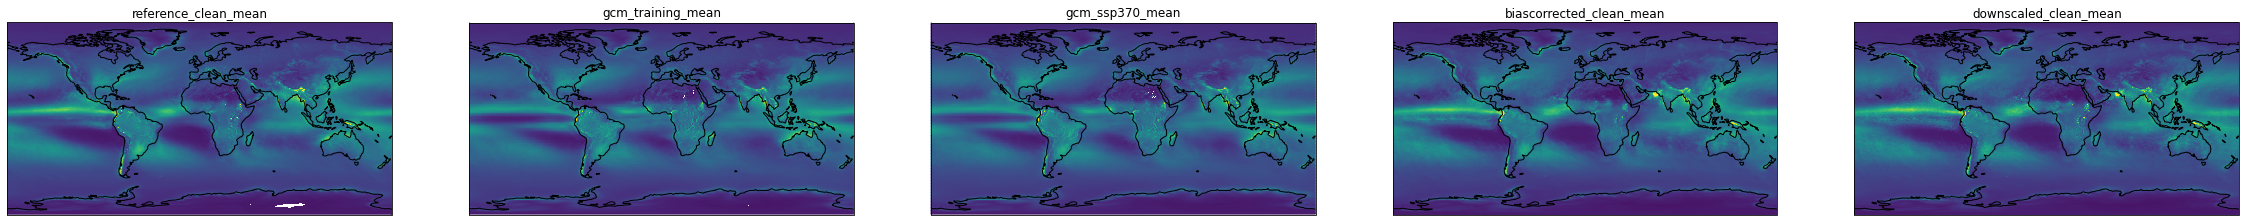

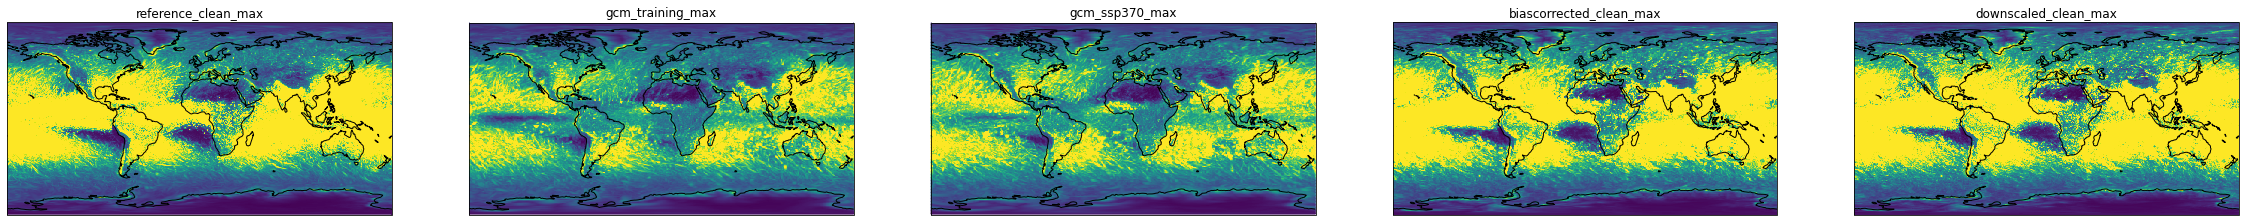

In [109]:
series_two_decades(start='2020', end='2040', datadict=datadict)

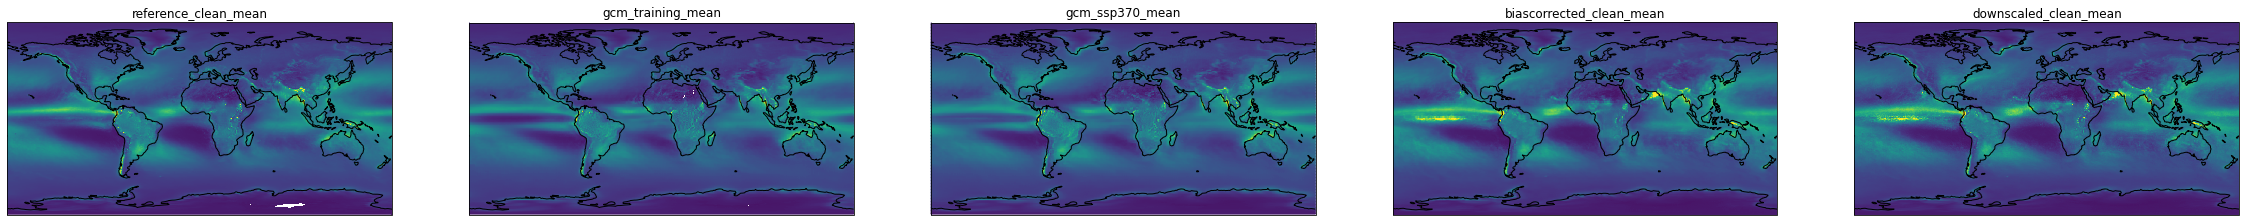

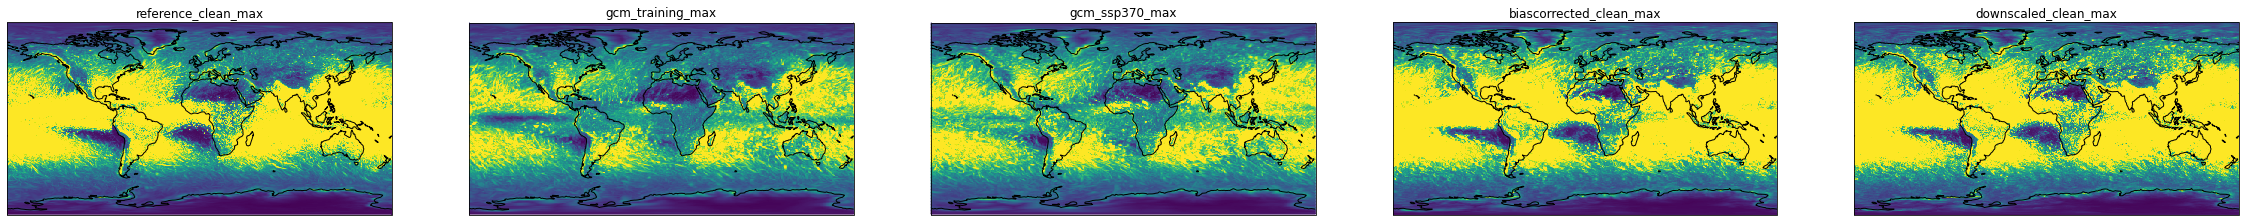

In [110]:
series_two_decades(start='2040', end='2060', datadict=datadict)

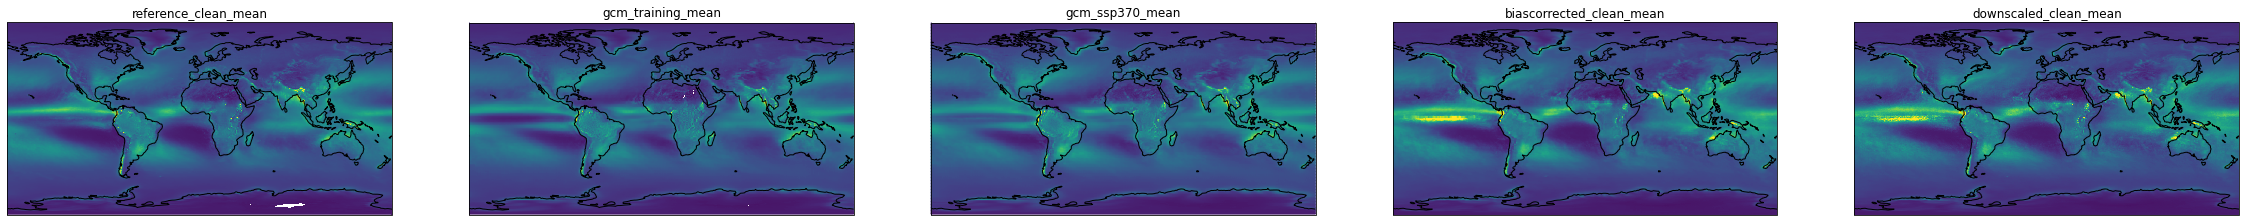

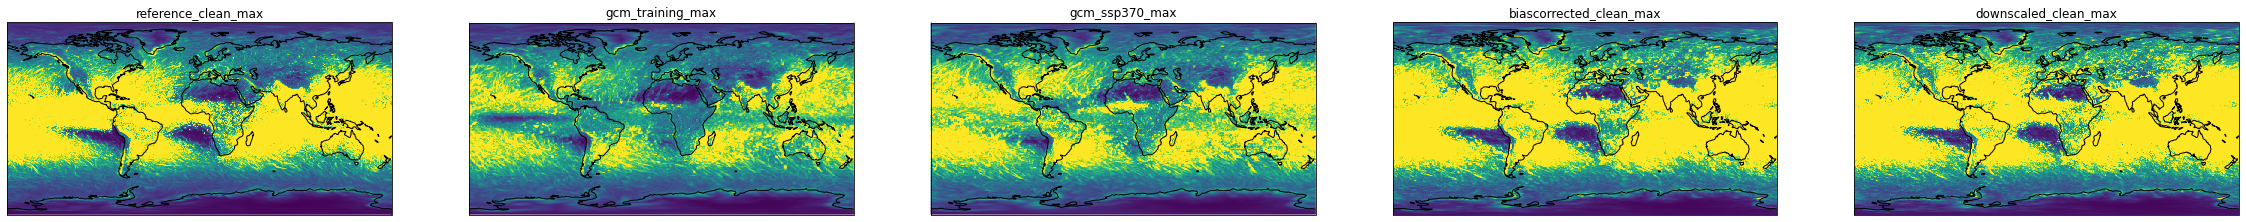

In [113]:
series_two_decades(start='2060', end='2080', datadict=datadict)

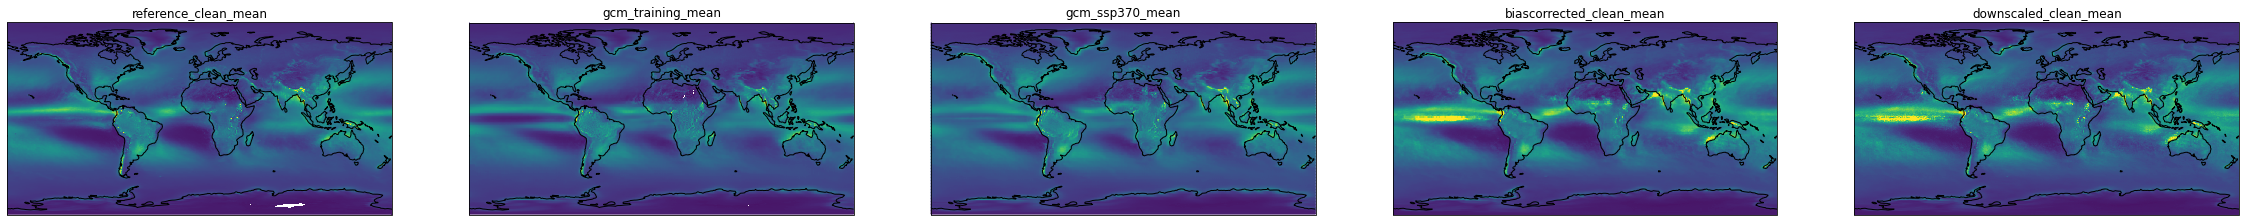

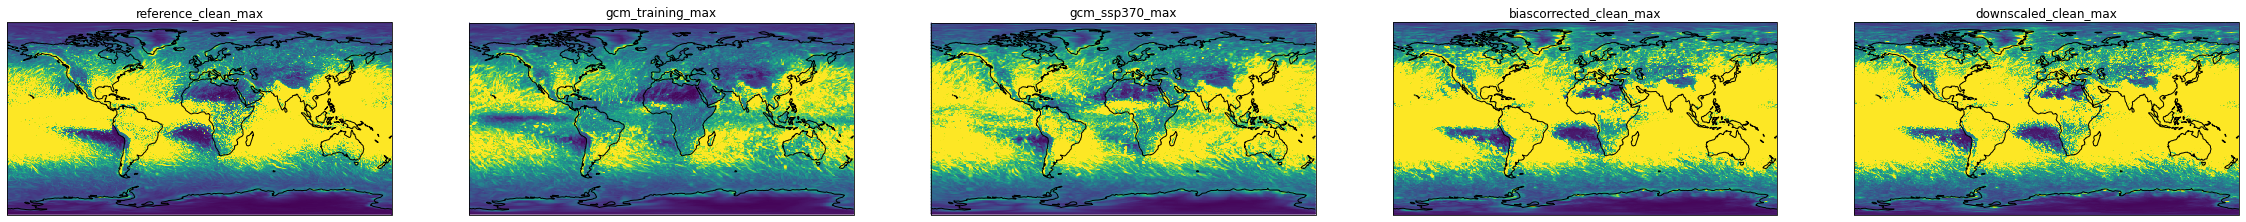

In [116]:
series_two_decades(start='2080', end='2100', datadict=datadict)

## 2. Deeper dive into a few cells distribution across time (again, bidecadal)

##### Seoul 36.72 127.18
##### Paris 49.18 2.14
##### Kolkata 22.56 88.36
##### Niamey 13.69 2.31 
##### Arabian sea (South of Pakistan) 22.54 56.88 
(The latter in particular sheds light on what the averages maps show)

### Three empirical distribution function plots (distribution across time for a given cell) with a curve for each dataset :
#### - for the QDM method check : 
    - reference, training, gcm-future-clean, gcm-future-biascorrected, gcm-future-downscaled
    - same as the above zooming in highest quantiles
#### - for the QPLAD method check : 
    - reference-fine, reference-coarse, biascorrected, downscaled (zooming in highest quantiles)

In [150]:
def series_cities_two_decades(city, start, end, datadict, zoom_in=(0.95, 1.0)):
   
    citydict = {
        'Seoul':[36.72, 127.18],
        'Paris':[49.18, 2.14],
        'Niamey':[13.69, 2.31],
        'Kolkata':[22.56, 88.36],
        'Arabian Sea':[22.54, 56.88]
    }
    
    lat, lon = citydict[city][0],citydict[city][1]
    
    reference_clean = datadict['reference-clean'].sel({'time': slice('1994-12-17', '2015-01-15', None)}).sel(lat=lat, lon=lon, method='nearest').compute()
    gcm_training = datadict['gcm-clean-historical'].sel({'time': slice('1994-12-17', '2015-01-15', None)}).sel(lat=lat, lon=lon, method='nearest').compute()
    gcm_clean = datadict['gcm-clean'].sel(time=slice(start, end)).sel(lat=lat, lon=lon, method='nearest').compute()
    biascorrected = datadict['gcm-biascorrected'].sel(time=slice(start, end)).sel(lat=lat, lon=lon, method='nearest').compute()
    downscaled = datadict['gcm-downscaled'].sel(time=slice(start, end)).sel(lat=lat, lon=lon, method='nearest').compute()
    reference_qplad_fine = datadict['reference-qplad-fine'].sel({'time': slice('1994-12-17', '2015-01-15', None)}).sel(lat=lat, lon=lon, method='nearest').compute()
    reference_qplad_coarse = datadict['reference-qplad-coarse'].sel({'time': slice('1994-12-17', '2015-01-15', None)}).sel(lat=lat, lon=lon, method='nearest').compute()
    
    plt.figure(figsize=(14, 4))
    sbn.ecdfplot(reference_clean, label='reference')
    sbn.ecdfplot(gcm_training, label='gcm-training')
    sbn.ecdfplot(gcm_clean, label='gcm-ssp370')
    sbn.ecdfplot(biascorrected, label='biascorrected')
    sbn.ecdfplot(downscaled,label='downscaled')
    plt.legend(bbox_to_anchor=(1.1, 1.05))
    plt.ylabel('quantile')
    plt.xlabel('precip (mm)')
    plt.title(f'{city} precip ECDF, all quantiles')
    
    plt.figure(figsize=(14, 4))
    sbn.ecdfplot(reference_clean, label='reference')
    sbn.ecdfplot(gcm_training, label='gcm-training')
    sbn.ecdfplot(gcm_clean, label='gcm-ssp370')
    sbn.ecdfplot(biascorrected, label='biascorrected')
    sbn.ecdfplot(downscaled,label='downscaled')
    plt.ylim(zoom_in[0], zoom_in[1])
    plt.legend(bbox_to_anchor=(1.1, 1.05))
    plt.ylabel('quantile')
    plt.xlabel('precip (mm)')
    plt.title(f'{city} precip ECDF, zooming in highest quantiles')
    
    plt.figure(figsize=(14, 4))
    sbn.ecdfplot(reference_qplad_fine, label='reference-qplad-fine')
    sbn.ecdfplot(reference_qplad_coarse, label='reference-qplad-coarse')
    sbn.ecdfplot(biascorrected, label='biascorrected')
    sbn.ecdfplot(downscaled,label='downscaled')
    plt.ylim(zoom_in[0], zoom_in[1])
    plt.legend(bbox_to_anchor=(1.1, 1.05))
    plt.ylabel('quantile')
    plt.xlabel('precip (mm)')
    plt.title(f'{city} precip ECDF, zooming in highest quantiles')

## Seoul

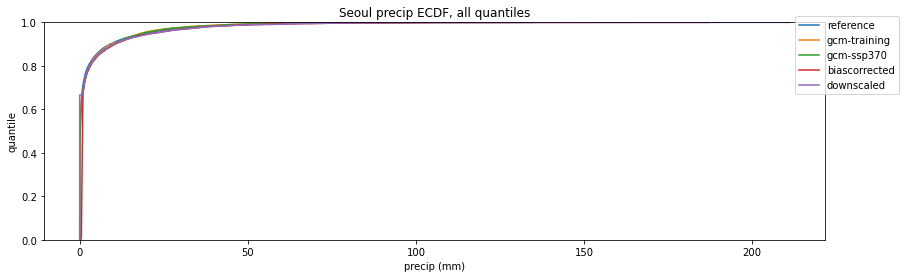

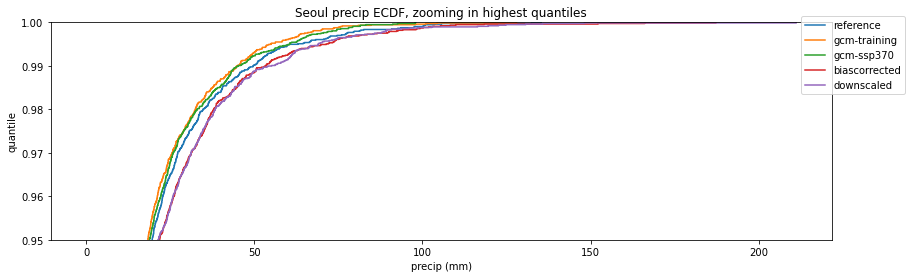

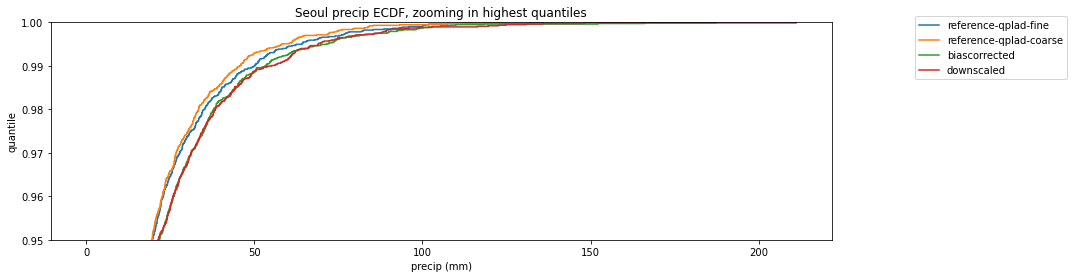

In [127]:
%%capture --no-display
series_cities_two_decades(city='Seoul', start='2020', end='2040', datadict=datadict)

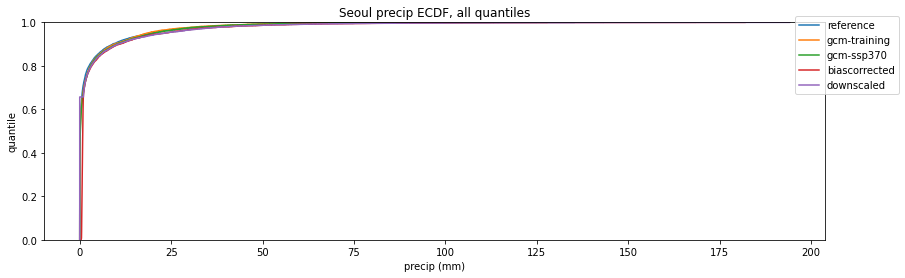

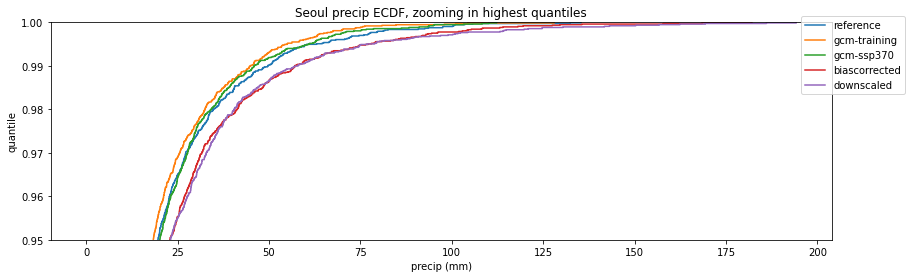

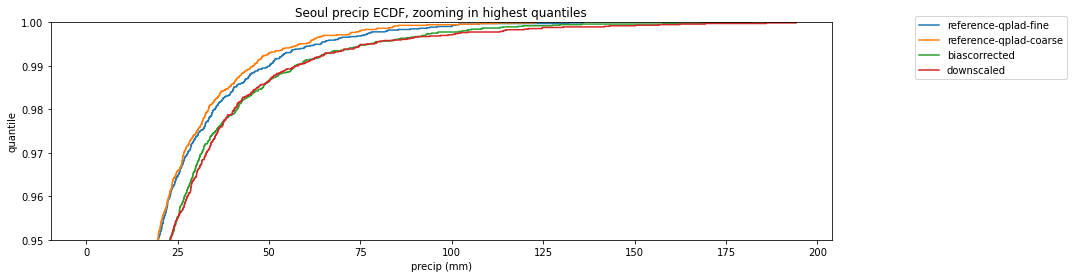

In [128]:
%%capture --no-display
series_cities_two_decades(city='Seoul', start='2040', end='2060', datadict=datadict)

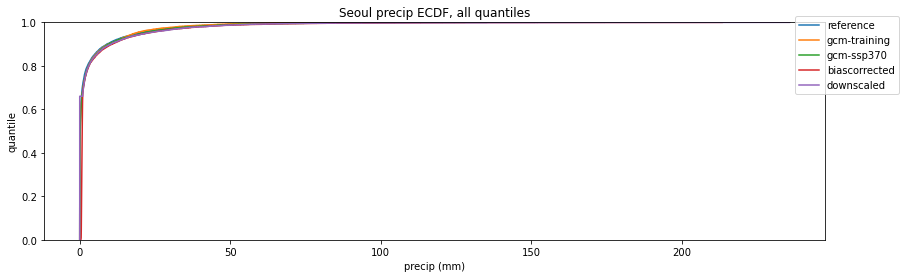

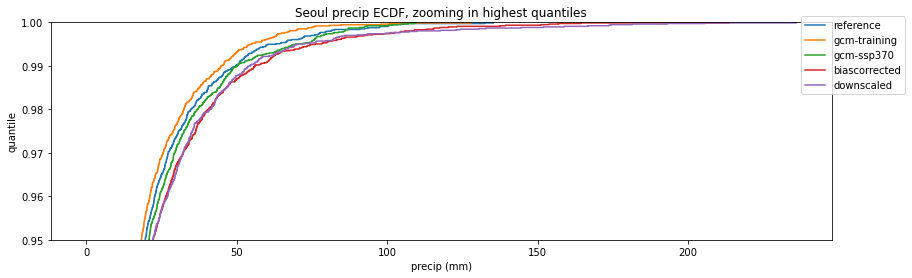

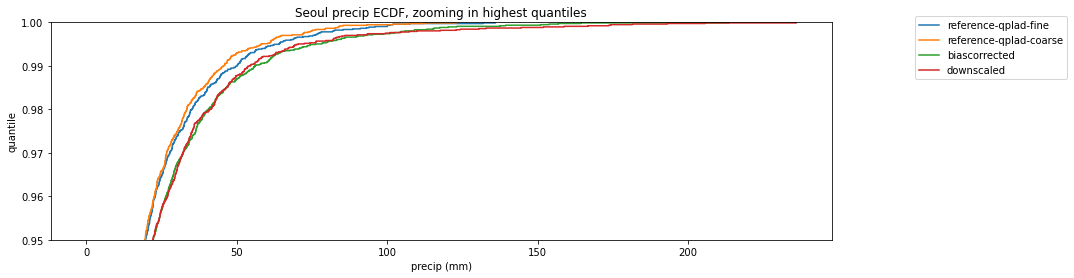

In [129]:
%%capture --no-display
series_cities_two_decades(city='Seoul', start='2060', end='2080', datadict=datadict)

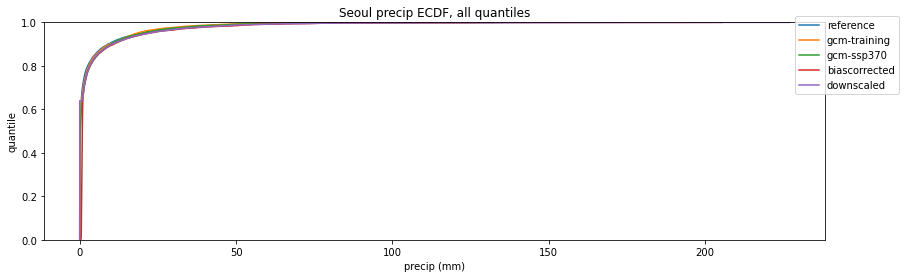

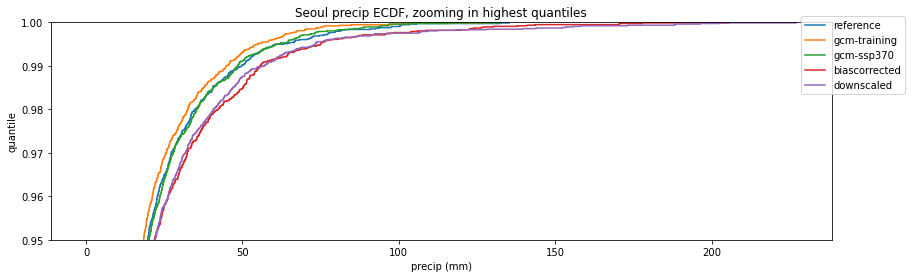

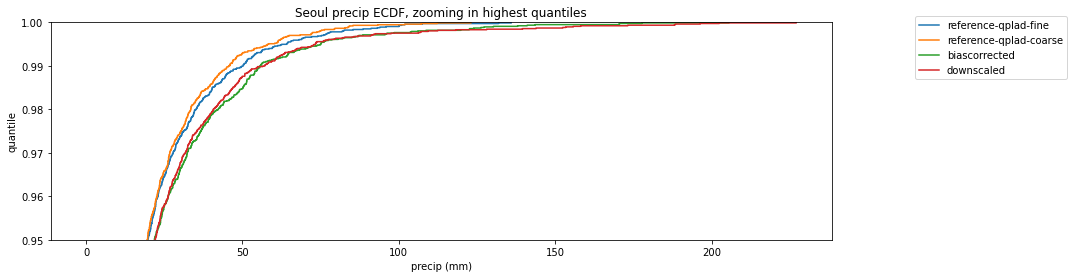

In [130]:
%%capture --no-display
series_cities_two_decades(city='Seoul', start='2080', end='2100', datadict=datadict)

## Paris

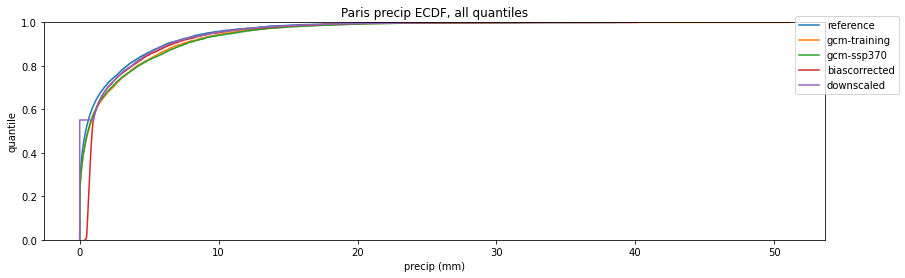

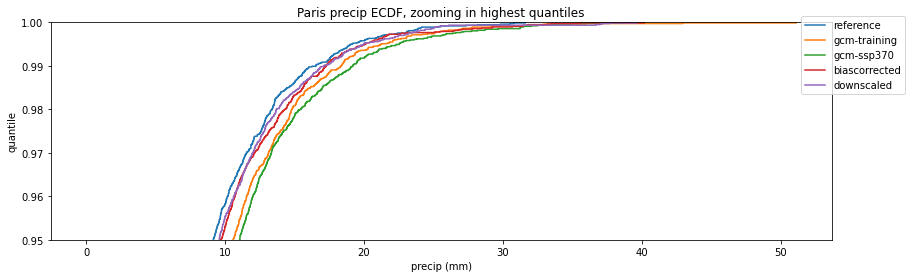

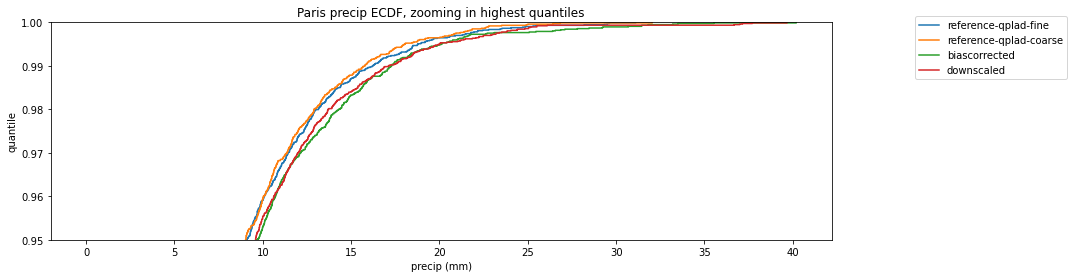

In [131]:
%%capture --no-display
series_cities_two_decades(city='Paris', start='2020', end='2040', datadict=datadict)

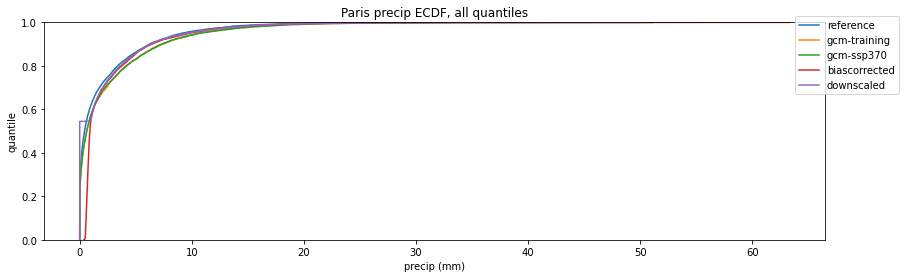

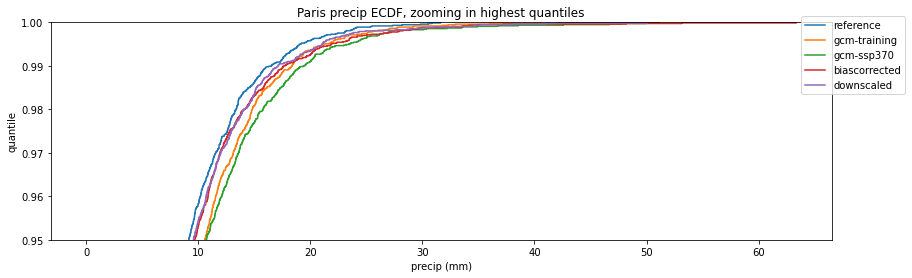

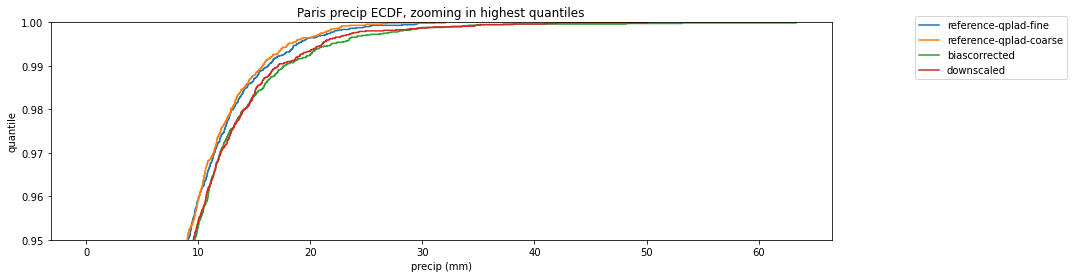

In [132]:
%%capture --no-display
series_cities_two_decades(city='Paris', start='2040', end='2060', datadict=datadict)

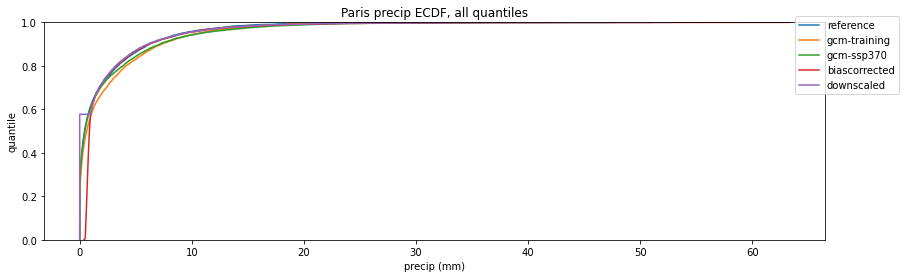

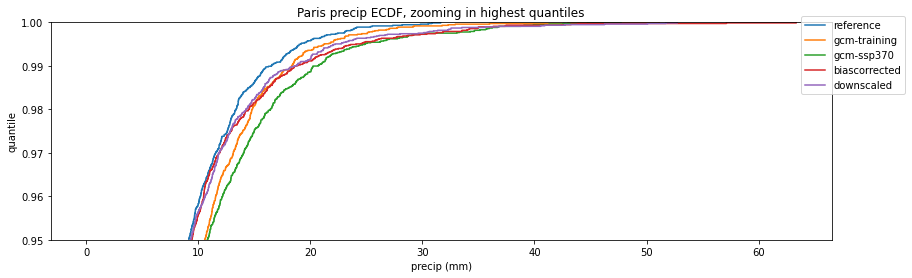

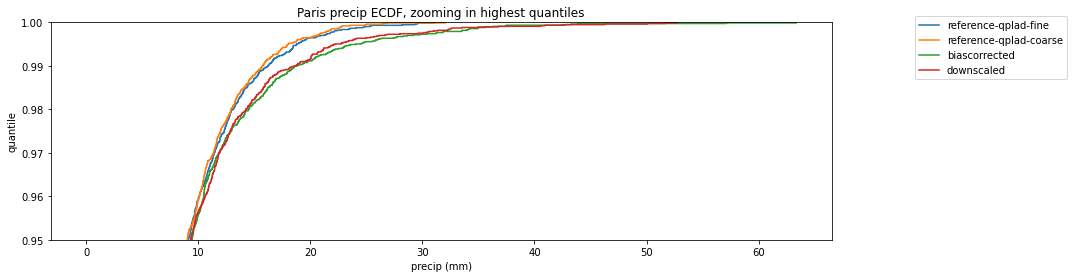

In [133]:
%%capture --no-display
series_cities_two_decades(city='Paris', start='2060', end='2080', datadict=datadict)

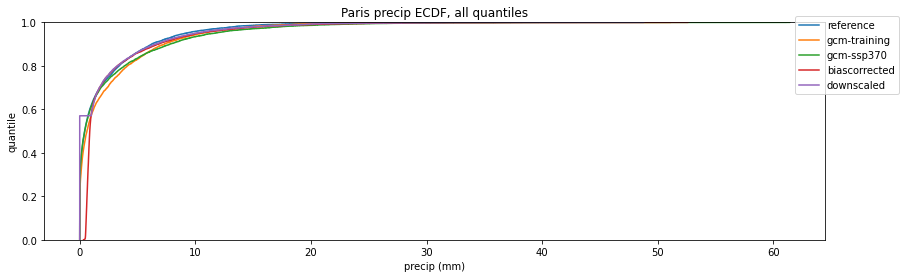

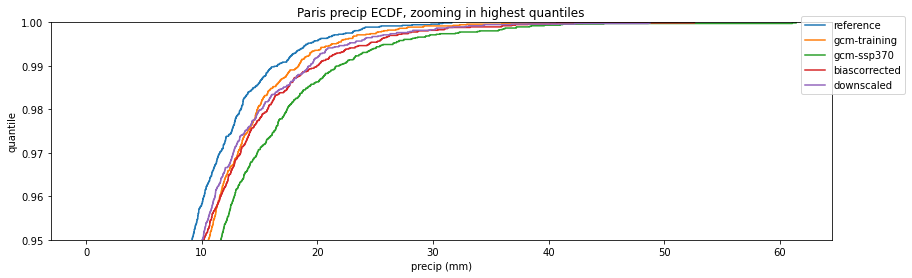

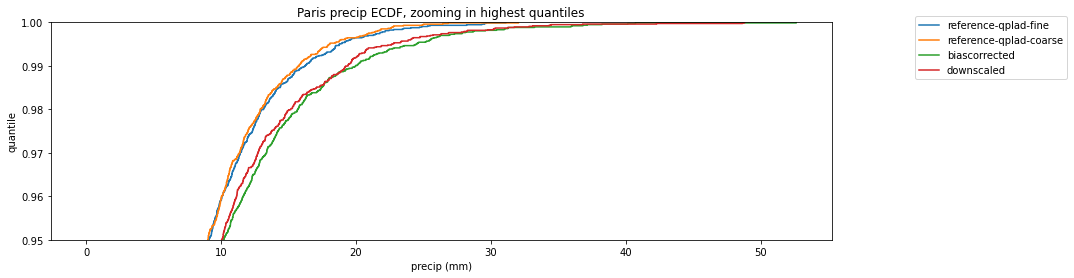

In [134]:
%%capture --no-display
series_cities_two_decades(city='Paris', start='2080', end='2100', datadict=datadict)

## Niamey

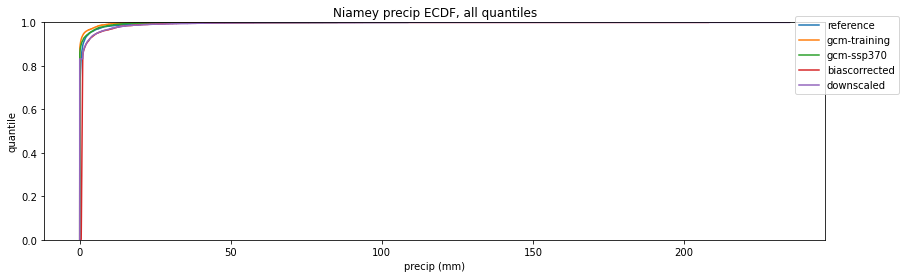

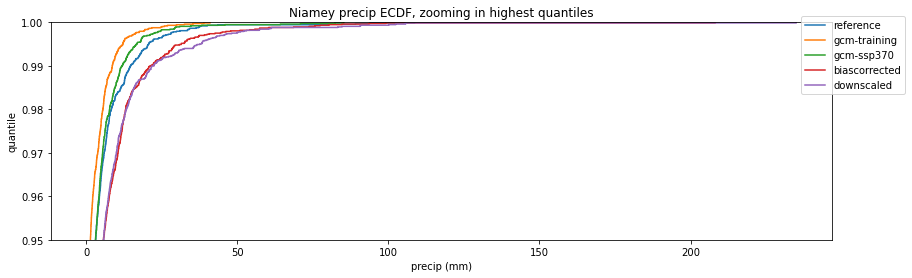

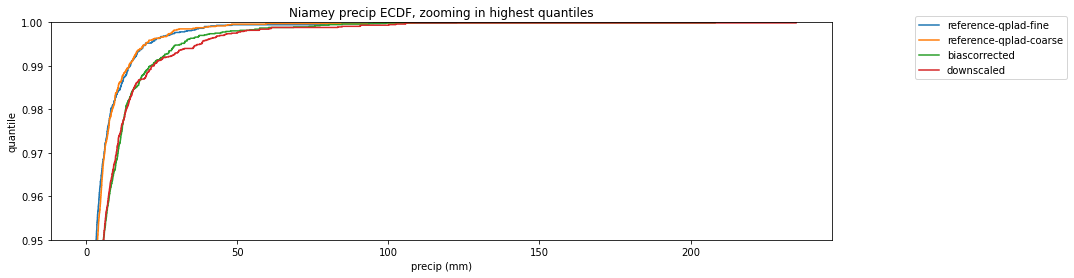

In [135]:
%%capture --no-display
series_cities_two_decades(city='Niamey', start='2020', end='2040', datadict=datadict)

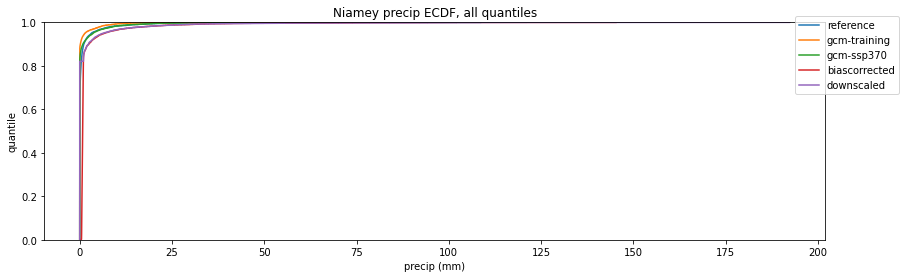

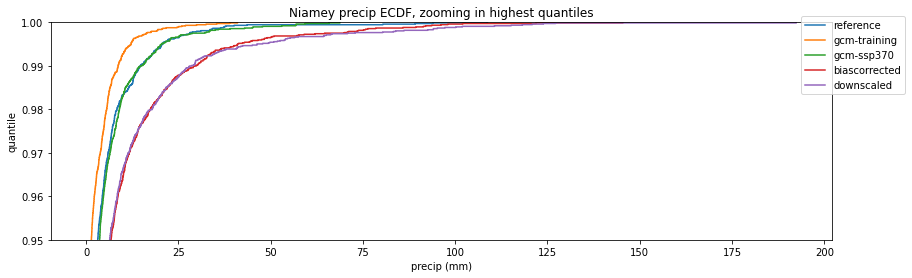

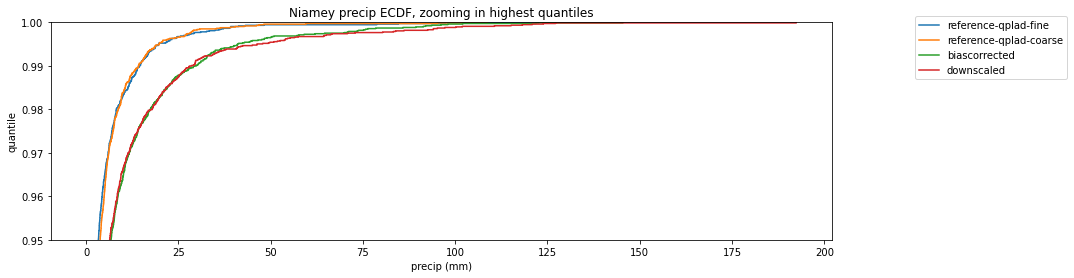

In [136]:
%%capture --no-display
series_cities_two_decades(city='Niamey', start='2040', end='2060', datadict=datadict)

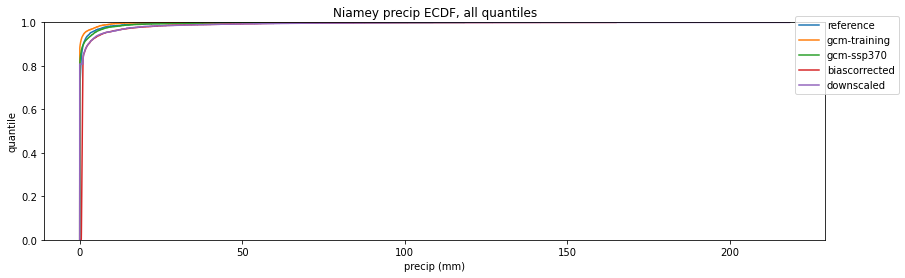

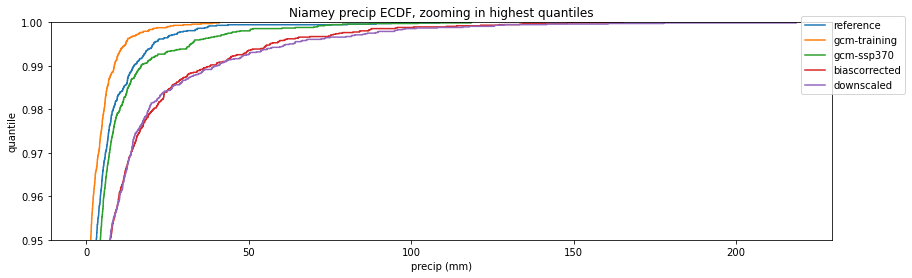

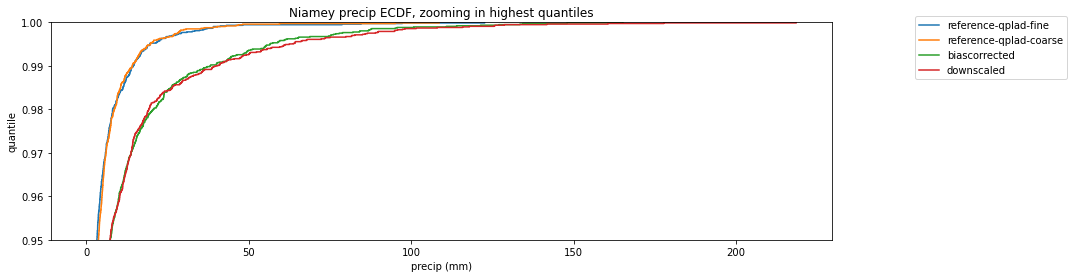

In [137]:
%%capture --no-display
series_cities_two_decades(city='Niamey', start='2060', end='2080', datadict=datadict)

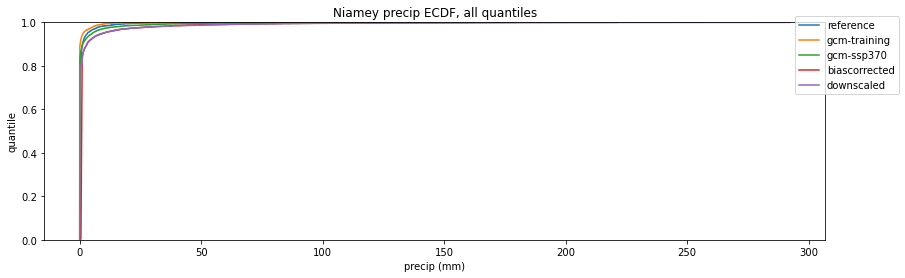

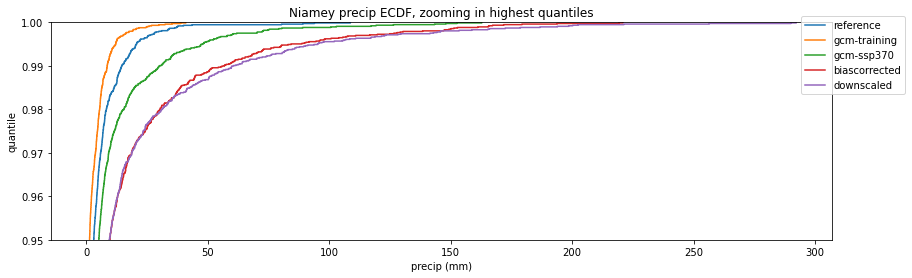

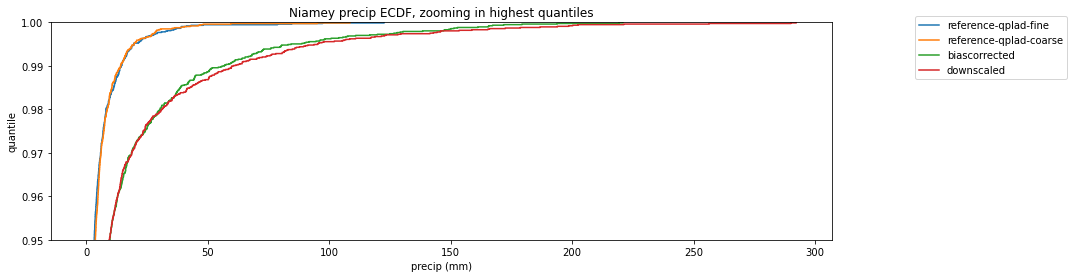

In [138]:
%%capture --no-display
series_cities_two_decades(city='Niamey', start='2080', end='2100', datadict=datadict)

## Kolkata

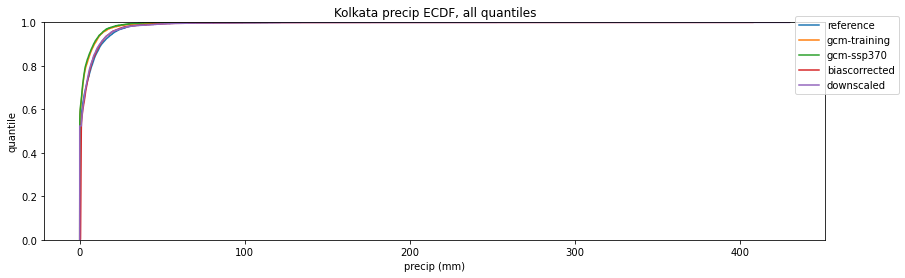

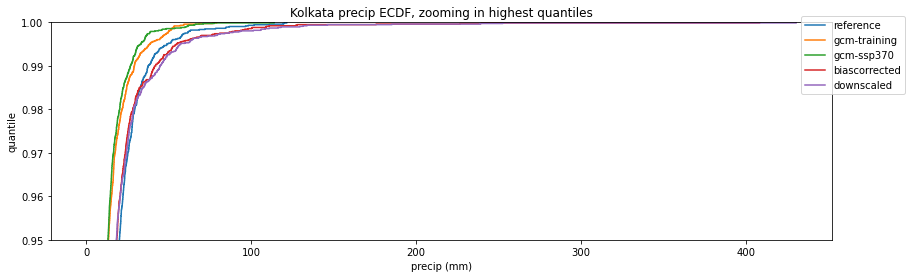

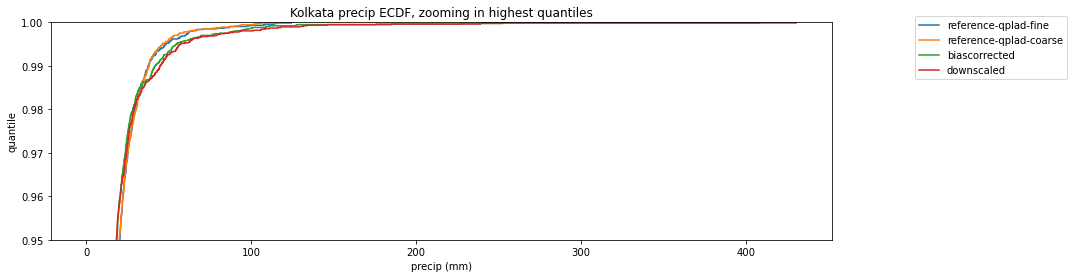

In [139]:
%%capture --no-display
series_cities_two_decades(city='Kolkata', start='2020', end='2040', datadict=datadict)

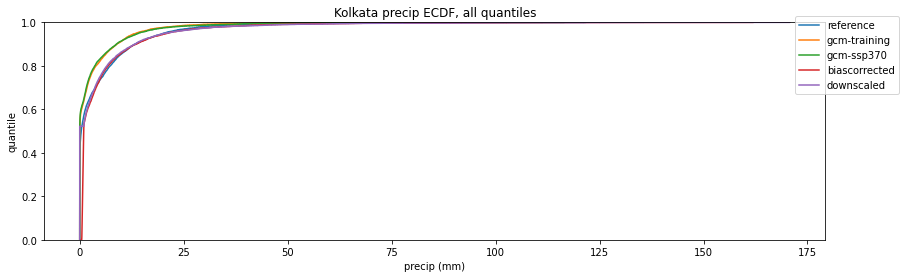

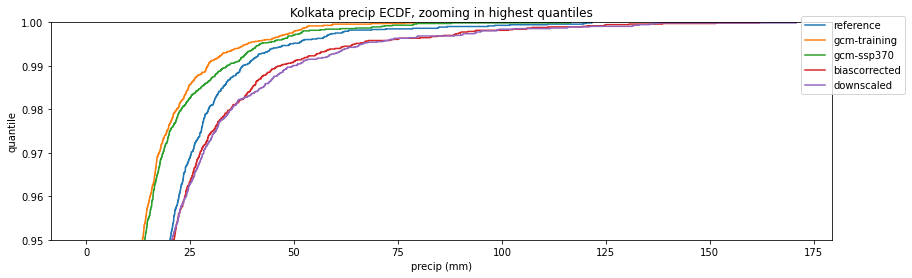

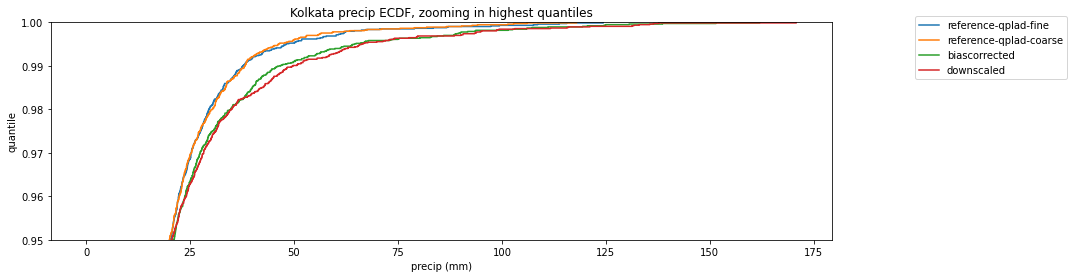

In [140]:
%%capture --no-display
series_cities_two_decades(city='Kolkata', start='2040', end='2060', datadict=datadict)

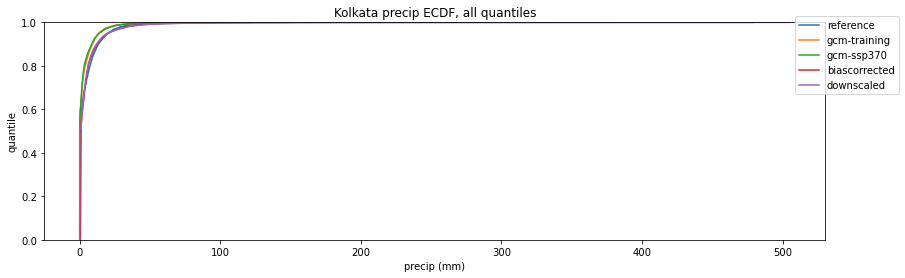

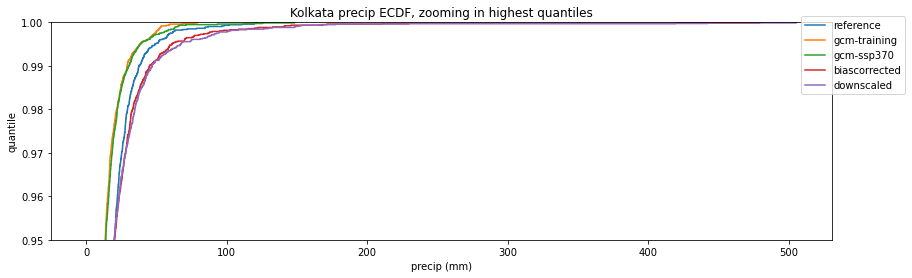

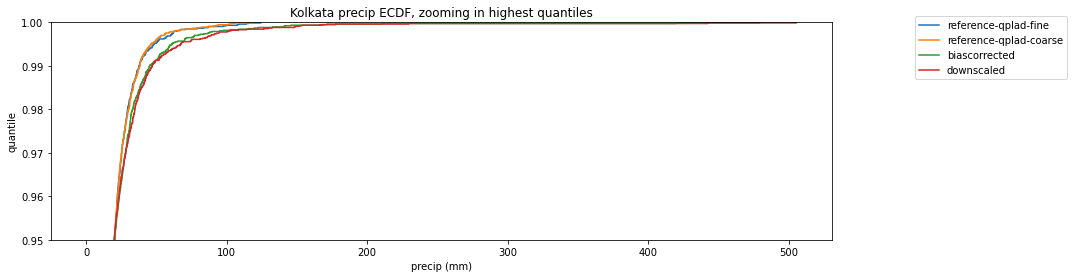

In [141]:
%%capture --no-display
series_cities_two_decades(city='Kolkata', start='2060', end='2080', datadict=datadict)

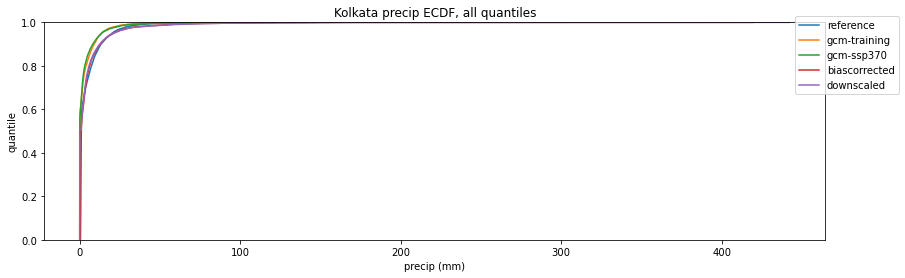

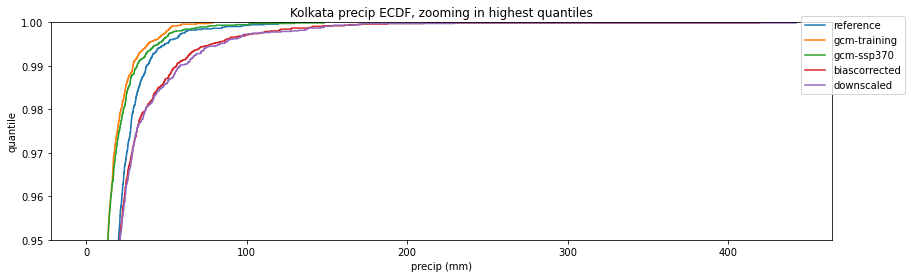

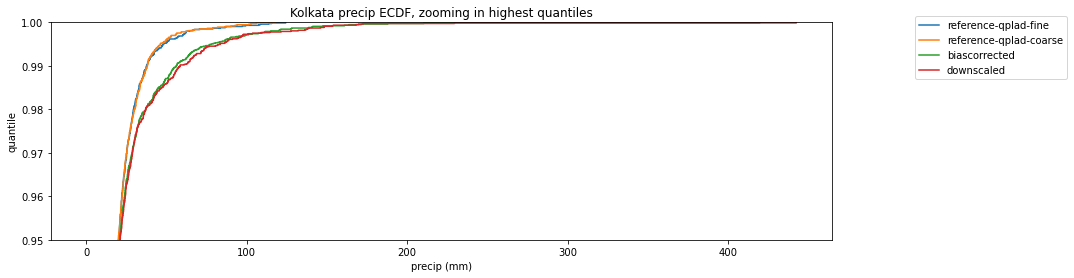

In [142]:
%%capture --no-display
series_cities_two_decades(city='Kolkata', start='2080', end='2100', datadict=datadict)

## Arabian Sea, south of Pakistan

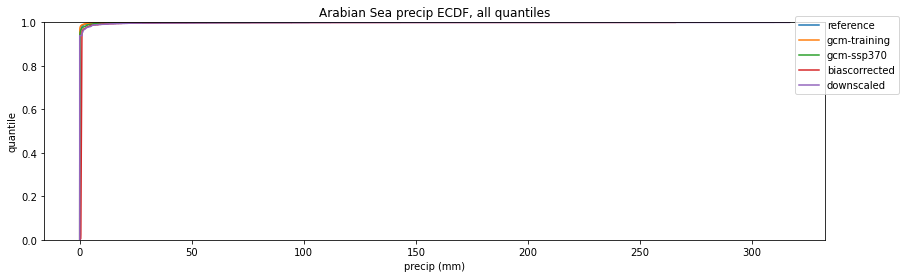

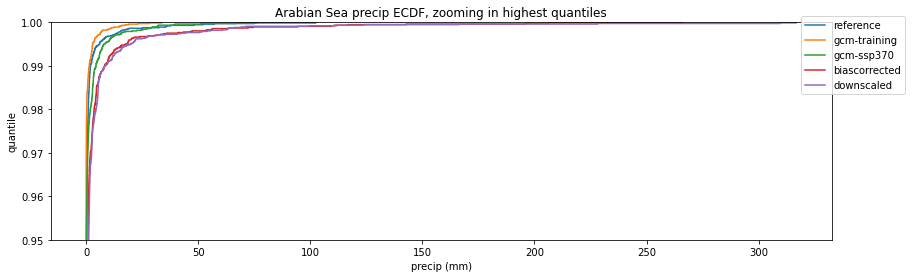

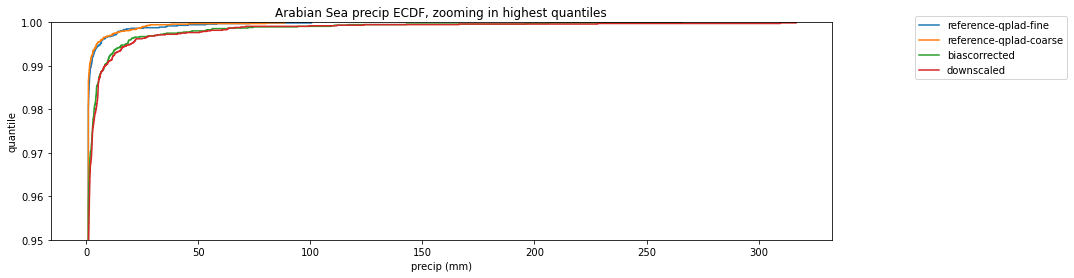

In [149]:
%%capture --no-display
series_cities_two_decades(city='Arabian Sea', start='2080', end='2100', datadict=datadict)

#### quantiles between [0.98, 1.0]

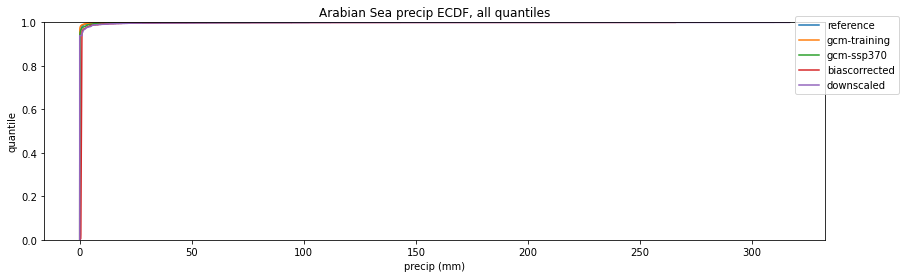

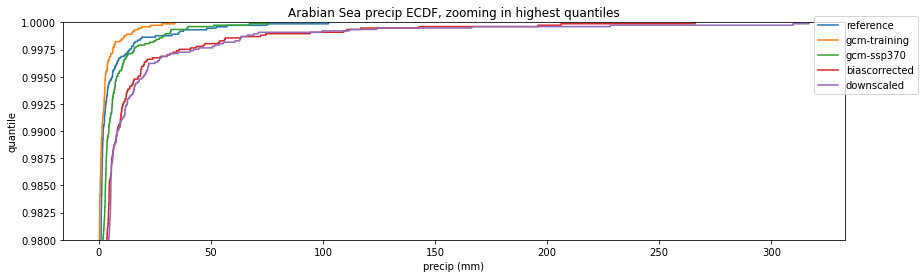

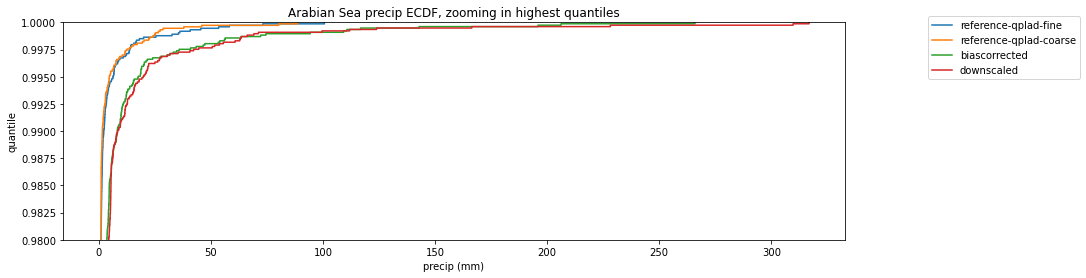

In [151]:
%%capture --no-display
series_cities_two_decades(city='Arabian Sea', start='2080', end='2100', datadict=datadict, zoom_in=(0.98, 1.0))